In [3]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
import glob
import matplotlib.pyplot as plt

awkward version  1.7.0
coffea version  0.7.11


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9qzgws72 because the default path (/home/cms-jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
f = uproot.open('/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root')

In [5]:
f["Events"].keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'nboostedTau',
 'boostedTau_chargedIso',
 'boostedTau_eta',
 'boostedTau_leadTkDeltaEta',
 'boostedTau_leadTkDeltaPhi',
 'boostedTau_leadTkPtOverTauPt',
 'boostedTau_mass',
 'boostedTau_neutralIso',
 'boostedTau_phi',
 'boostedTau_photonsOutsideSignalCone',
 'boostedTau_pt',
 'boostedTau_puCorr',
 'boostedTau_rawAntiEle2018',
 'boostedTau_rawIso',
 'boostedTau_rawIsodR03',
 'boostedTau_rawMVAnewDM2017v2',
 'boostedTau_rawMVAoldDM2017v2',
 'boostedTau_rawMVAoldDMdR032017v2',
 'boostedTau_charge',
 'boostedTau_decayMode',
 'boostedTau_je

In [6]:
f["Events"]["Generator_binvar"].arrays()

<Array [{Generator_binvar: 29.3, ... ] type='1596000 * {"Generator_binvar": floa...'>

In [7]:
eras = [
    'UL16NanoAOD', 
    'UL16NanoAODAPV', 
    'UL17NanoAOD', 
    'UL18NanoAOD'
       ]

filestr1 = '/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/*/*.root'
filestr2 = '/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/*/*.root'
fileset = {"2016":[], "2016APV":[]}


infiles1 = glob.glob(filestr1)
fileset["2016"] = fileset["2016"] + [*infiles1]
infiles2 = glob.glob(filestr2)
fileset["2016APV"] = fileset["2016APV"] + [*infiles2]

In [68]:
class Counter(processor.ProcessorABC):
    def __init__(self ):
        weights_axis = hist.axis.Regular(100, -50, 0, name="w", label="Weights")
        pt_axis = hist.axis.Regular( 700, 0, 7000, 
                                     name="pt", label="Pt")

#        pt_axis = hist.axis.Variable( [0,10,20,30,40,50,60,70,80,90,
#                                       100,110,120,130,140,150,160,170,180,190,
#                                       200,210,220,230,240,250,260,270,280,290,
#                                       300,310,320,330,340,350,360,370,380,390,
#                                       400,410,420,430,440,450,460,470,480,490,
#                                       500,510,520,530,540,550,560,570,580,590,
#                                       1000,2000,3000,4000,5000,6000,7000], 
#                                     name="pt", label="Pt")
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        
        ### Plots of things during the selection process / for debugging with fine binning
        h_w = hist.Hist(dataset_axis, weights_axis, pt_axis, storage="weight", label="Counts")
        self.hists = {
            "w":h_w
        }
        
        self.means_stddevs = defaultdict()
    
    @property
    def accumulator(self):
        return self.hists

    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        dataset = events.metadata['dataset']
        
        ht = ak.sum( events["Jet"].pt, axis=1 )
        htgood = ht > 1100.
        events = events[htgood]

        #print("weights ", np.log(events["Generator"].weight))
        #print("binvar  ", events["Generator"].binvar)
        self.hists['w'].fill( dataset=dataset, w=np.log(events["Generator"].weight), pt=events["Generator"].binvar )
        weirdweight = (np.abs(events["Generator"].weight - 1.46125241e-06) / 1.46125241e-06 < 1e-4)

        weird = weirdweight
        
        print(events["Generator"].weight[weird] )
        print(events["Generator"].binvar[weird] )
                
        return self.hists

    
    def postprocess(self, accumulator):
        return accumulator
    
    
    

In [69]:
run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=NanoAODSchema,
    chunksize=1000000,
    maxchunks=None
)

output = run(
    fileset,
    "Events",
    processor_instance=Counter(),
)

Processing:   0%|          | 0/57 [00:00<?, ?chunk/s]

[]
[]
[]
[]
[]
[]
[]
[]
[1.46e-06]
[328]
[]
[]
[]
[]
[1.46e-06]
[328]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.46e-06]
[328]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.46e-06]
[328]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.46e-06]
[328]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [62]:
output

{'w': Hist(
   StrCategory(['2016APV', '2016'], growth=True, name='dataset', label='Primary dataset'),
   Regular(100, -50, 0, name='w', label='Weights'),
   Variable(array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
         540.,  550.,  560.,  570.,  580.,  590., 1000., 2000., 3000.,
        4000., 5000., 6000., 7000.]), name='pt', label='Pt'),
   storage=Weight()) # Sum: WeightedSum(value=1.5771e+07, variance=1.5771e+07) (WeightedSum(value=1.57717e+07, variance=1.57717e+07) with flow)}

In [38]:
w, x, y = output['w'][0,:,:].to_numpy()

/tmp/ipykernel_21911/3030528889.py:1: RuntimeWarning: divide by zero encountered in log
  mesh = plt.pcolormesh(x,y, np.log(w.T), cmap="Greys", vmin=1e-8, vmax=1e-3 )


(-15.0, 0.0)

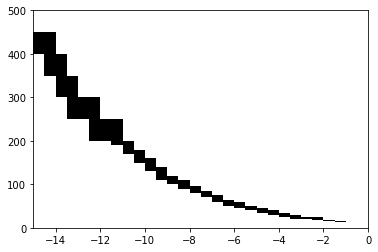

In [45]:
mesh = plt.pcolormesh(x,y, np.log(w.T), cmap="Greys", vmin=1e-8, vmax=1e-3 )
plt.ylim(0,500)
plt.xlim(-15,0)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd4fc25b1f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

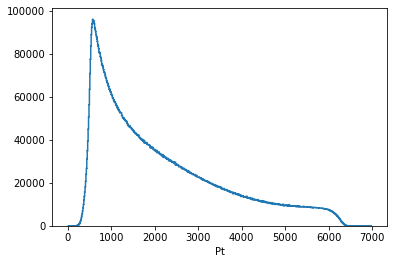

In [75]:
output['w'].project("pt").plot()
#plt.yscale("log")
#plt.xlim(0,1000)